# **Tech Challenge - IBOVESPA**

## **1. Introdução**

Este projeto tem como foco a construção de um modelo preditivo para analisar e prever a tendência diária do índice IBOVESPA, indicando se seu fechamento será em alta ou baixa no dia seguinte. \
A iniciativa faz parte de um Tech Challenge proposto por um fundo de investimentos brasileiro, visando fornecer um insumo valioso para a tomada de decisões.

## **2. Objetivo**

O objetivo é criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior (↑) ou menor (↓) que o do dia atual.

**Métricas esperadas:**
* O modelo deve alcançar uma acurácia mínima de 75% na previsão da tendência em um conjunto de teste.
* O conjunto de testes deverá conter o último mês (30 dias) de dados disponíveis.

**Entregas esperadas:**
* **Storytelling Técnico:** Uma apresentação (PPT, PDF ou ferramenta de sua preferência) detalhando a aquisição e exploração dos dados, estratégia de engenharia de atributos, preparação da base, escolha e justificativa do modelo, e análise das métricas e resultados.
* **Justificativa Técnica:** Uma explicação clara sobre os modelos utilizados, como a natureza sequencial dos dados foi tratada (ex: janelas deslizantes, features lagged), e os trade-offs entre acurácia e overfitting.
* **Arquivo do Projeto:** Uma pasta .zip contendo todos os arquivos do projeto, ou um link para o repositório do GitHub.
* **Vídeo:** Um vídeo de no máximo 5 minutos, com uma visão gerencial, explicando como interpretar os resultados obtidos. Todos os membros do grupo devem aparecer no vídeo.


## **3. Dataset, Variáveis e Bibliotecas**

Dataset:
* **Ibovespa:** Download dataset site ibovespa, com períodos de 10 e 20 anos para o devido treinamento.
* Link para o download:  https://br.investing.com/indices/bovespa-historical-data

Variáveis presentes no DataFrame:

* **data_pregao:** Data de funcionamento do pregão.
* **preco_fechamento:** Preço final do IBOVESPA no dia.
* **preco_abertura:** Preço inicial do IBOVESPA no dia.
* **preco_maximo:** Preço mais alto que o IBOVESPA atingiu no dia.
* **preco_minimo:** Preço mais baixo que o IBOVESPA atingiu no dia.
* **volume:** Quantidade de negociações no dia.
* **variacao:** Mudança no preço em relação ao dia anterior (pode ser em pontos ou percentual).

Bibliotecas:
* Pandas
* Numpy
* Matplotlib
* Seaborn
* Sickit-Learn



## **4. Análise Exploratória dos Dados (EDA)**

In [2]:
#Importando bibliotecas utilizadas para manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno

#Importando o modelos de machine learning
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#Importando métricas de avaliação e validação
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler


In [3]:
#Base de dados importada: 10 anos (19/01/2015 à 18/07/2025)
df_ibovespa = pd.read_csv(r"D:\Cursos\FIAP\ibovespa\dataset\dados_historicos_ibovespa_10anos.csv", sep=",")

In [4]:
df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
1,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"
2,16.07.2025,135.511,135.250,135.641,134.265,"7,83B","0,19%"
3,15.07.2025,135.250,135.298,136.022,134.380,"6,90B","-0,04%"
4,14.07.2025,135.299,136.187,136.187,134.840,"7,33B","-0,65%"
...,...,...,...,...,...,...,...
2599,23.01.2015,48.775,49.432,49.523,48.496,"3,08M","-1,35%"
2600,22.01.2015,49.443,49.227,50.281,49.227,"4,95M","0,44%"
2601,21.01.2015,49.224,47.888,49.329,47.888,"3,56M","2,81%"
2602,20.01.2015,47.877,47.759,48.687,47.619,"2,90M","0,25%"


In [5]:
#Verificando os primeiros registros com o .head()
df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
1,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"
2,16.07.2025,135.511,135.250,135.641,134.265,"7,83B","0,19%"
3,15.07.2025,135.250,135.298,136.022,134.380,"6,90B","-0,04%"
4,14.07.2025,135.299,136.187,136.187,134.840,"7,33B","-0,65%"


In [6]:
#Verificando os últimos registros com o .tail()
df_ibovespa.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
2599,23.01.2015,48.775,49.432,49.523,48.496,"3,08M","-1,35%"
2600,22.01.2015,49.443,49.227,50.281,49.227,"4,95M","0,44%"
2601,21.01.2015,49.224,47.888,49.329,47.888,"3,56M","2,81%"
2602,20.01.2015,47.877,47.759,48.687,47.619,"2,90M","0,25%"
2603,19.01.2015,47.758,49.009,49.009,47.503,"2,10M","-2,57%"


In [7]:
#Verificando as colunas
df_ibovespa.columns

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')

In [8]:
#Renomeando colunas para fácil leitura dos dados
df_ibovespa.rename(columns={'Data': 'data_pregao',
    'Último': 'preco_fechamento',
    'Abertura': 'preco_abertura',
    'Máxima': 'preco_maximo',
    'Mínima': 'preco_minimo',
    'Vol.': 'volume',
    'Var%': 'variacao'}, inplace=True)

df_ibovespa.columns

Index(['data_pregao', 'preco_fechamento', 'preco_abertura', 'preco_maximo',
       'preco_minimo', 'volume', 'variacao'],
      dtype='object')

In [9]:
#Verificando os tipos de dados existentes no DataFrame
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604 entries, 0 to 2603
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   data_pregao       2604 non-null   object 
 1   preco_fechamento  2604 non-null   float64
 2   preco_abertura    2604 non-null   float64
 3   preco_maximo      2604 non-null   float64
 4   preco_minimo      2604 non-null   float64
 5   volume            2603 non-null   object 
 6   variacao          2604 non-null   object 
dtypes: float64(4), object(3)
memory usage: 142.5+ KB


In [10]:
df_ibovespa.head(2)

,data_pregao,preco_fechamento,preco_abertura,preco_maximo,preco_minimo,volume,variacao
0,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
1,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"


In [11]:
#Convertendo o tipo de data
df_ibovespa['data_pregao'] = pd.to_datetime(df_ibovespa.data_pregao, format='%d.%m.%Y')

#Definição do 'data_pregao' como o índice do DataFrame
df_ibovespa = df_ibovespa.set_index('data_pregao')
print(f"\nNúmero de linhas antes: {len(df_ibovespa)}")

#Aplicando a inserção de dias faltantes relacionados a FDS e Feriados
df_ibovespa = df_ibovespa.asfreq('D').ffill()#Metodo .ffill() preenche os NaN com o útlimo valor válido observado
print(f"\nNúmero de linhas depois: {len(df_ibovespa)}")

#Ordenando o DataFrame pela data do pregão
#Isso é importante para garantir que os dados estejam em ordem cronológica
df_ibovespa.sort_values(by='data_pregao', inplace=True)


Número de linhas antes: 2604

Número de linhas depois: 3834


In [12]:
df_ibovespa.head(10)

,preco_fechamento,preco_abertura,preco_maximo,preco_minimo,volume,variacao
data_pregao,,,,,,
2015-01-19,47.758,49.009,49.009,47.503,"2,10M","-2,57%"
2015-01-20,47.877,47.759,48.687,47.619,"2,90M","0,25%"
2015-01-21,49.224,47.888,49.329,47.888,"3,56M","2,81%"
2015-01-22,49.443,49.227,50.281,49.227,"4,95M","0,44%"
2015-01-23,48.775,49.432,49.523,48.496,"3,08M","-1,35%"
2015-01-24,48.775,49.432,49.523,48.496,"3,08M","-1,35%"
2015-01-25,48.775,49.432,49.523,48.496,"3,08M","-1,35%"
2015-01-26,48.577,48.712,48.712,48.004,"2,77M","-0,41%"
2015-01-27,48.591,48.577,48.864,47.352,"3,89M","0,03%"


In [13]:
df_ibovespa.tail(10)

,preco_fechamento,preco_abertura,preco_maximo,preco_minimo,volume,variacao
data_pregao,,,,,,
2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
2025-07-10,136.743,137.472,137.472,136.014,"9,57B","-0,54%"
2025-07-11,136.187,136.742,136.742,135.528,"7,40B","-0,41%"
2025-07-12,136.187,136.742,136.742,135.528,"7,40B","-0,41%"
2025-07-13,136.187,136.742,136.742,135.528,"7,40B","-0,41%"
2025-07-14,135.299,136.187,136.187,134.840,"7,33B","-0,65%"
2025-07-15,135.250,135.298,136.022,134.380,"6,90B","-0,04%"
2025-07-16,135.511,135.250,135.641,134.265,"7,83B","0,19%"
2025-07-17,135.565,135.515,135.792,135.016,"6,80B","0,04%"


In [14]:
#Convertendo a coluna variacao
print("DataFrame antes da conversão da coluna 'variacao':")
print(df_ibovespa[['variacao']])
print(df_ibovespa['variacao'].dtype) #Tipo de dado atual
print("=" * 35)

DataFrame antes da conversão da coluna 'variacao':
            variacao
data_pregao         
2015-01-19    -2,57%
2015-01-20     0,25%
2015-01-21     2,81%
2015-01-22     0,44%
2015-01-23    -1,35%
...              ...
2025-07-14    -0,65%
2025-07-15    -0,04%
2025-07-16     0,19%
2025-07-17     0,04%
2025-07-18    -1,61%

[3834 rows x 1 columns]
object


In [15]:
#Usamos .str.replace('%', '') para aplicar a substituição em strings
df_ibovespa['variacao'] = df_ibovespa['variacao'].str.replace('%', '')

#Usamos .str.replace(',', '.') para substituir a vírgula por ponto
df_ibovespa['variacao'] = df_ibovespa['variacao'].str.replace(',', '.')

#Usamos pd.to_numeric() para converter. errors='coerce' é importante!
#Ele transformará qualquer valor que não puder ser convertido em número em NaN (Not a Number)
df_ibovespa['variacao'] = pd.to_numeric(df_ibovespa['variacao'], errors='coerce')

In [16]:
print("\nDataFrame após a conversão da coluna 'variacao':")
print(df_ibovespa[['variacao']])
print(df_ibovespa['variacao'].dtype) #Tipo de dado após a conversão
print("=" * 35)


DataFrame após a conversão da coluna 'variacao':
             variacao
data_pregao          
2015-01-19      -2.57
2015-01-20       0.25
2015-01-21       2.81
2015-01-22       0.44
2015-01-23      -1.35
...               ...
2025-07-14      -0.65
2025-07-15      -0.04
2025-07-16       0.19
2025-07-17       0.04
2025-07-18      -1.61

[3834 rows x 1 columns]
float64


In [17]:
#Convertendo a coluna volume
print("DataFrame antes da conversão da coluna 'volume':")
print(df_ibovespa[['volume']])
print(df_ibovespa['volume'].dtype) #Tipo de dado atual
print("=" * 40)

DataFrame antes da conversão da coluna 'volume':
             volume
data_pregao        
2015-01-19    2,10M
2015-01-20    2,90M
2015-01-21    3,56M
2015-01-22    4,95M
2015-01-23    3,08M
...             ...
2025-07-14    7,33B
2025-07-15    6,90B
2025-07-16    7,83B
2025-07-17    6,80B
2025-07-18   10,07B

[3834 rows x 1 columns]
object


In [18]:
#Função para tratar a coluna volume
def converter_volume(volume_str):
    if pd.isna(volume_str): #Verifica se o valor é NaN (caso de dados ausentes)
        return np.nan

    volume_str = str(volume_str).strip().upper() #Garante string e remove espaços, converte para maiúscula

    if 'K' in volume_str:
        return float(volume_str.replace('K', '').replace(',', '.')) * 1_000
    elif 'M' in volume_str:
        return float(volume_str.replace('M', '').replace(',', '.')) * 1_000_000
    elif 'B' in volume_str:
        return float(volume_str.replace('B', '').replace(',', '.')) * 1_000_000_000
    else:
        #Se não tiver K, M ou B, tenta converter diretamente (ex: '123' ou '123.45')
        try:
            return float(volume_str.replace(',', '.'))
        except ValueError:
            return np.nan #Retorna NaN se não conseguir converter

In [19]:
#Aplica a função à coluna volume
df_ibovespa['volume'] = df_ibovespa['volume'].apply(converter_volume)
df_ibovespa['volume'] = df_ibovespa['volume'].fillna(0).astype(np.int64)

In [20]:
print("DataFrame após a conversão da coluna 'volume':")
print(df_ibovespa[['volume']])
print(df_ibovespa['volume'].dtype) #Tipo de dado atual
print("=" * 35)

DataFrame após a conversão da coluna 'volume':
                  volume
data_pregao             
2015-01-19       2100000
2015-01-20       2900000
2015-01-21       3560000
2015-01-22       4950000
2015-01-23       3080000
...                  ...
2025-07-14    7330000000
2025-07-15    6900000000
2025-07-16    7830000000
2025-07-17    6800000000
2025-07-18   10070000000

[3834 rows x 1 columns]
int64


In [21]:
#Verificando se o conjunto de dados possui nulos
df_ibovespa.isnull().sum()

preco_fechamento    0
preco_abertura      0
preco_maximo        0
preco_minimo        0
volume              0
variacao            0
dtype: int64

<Axes: >

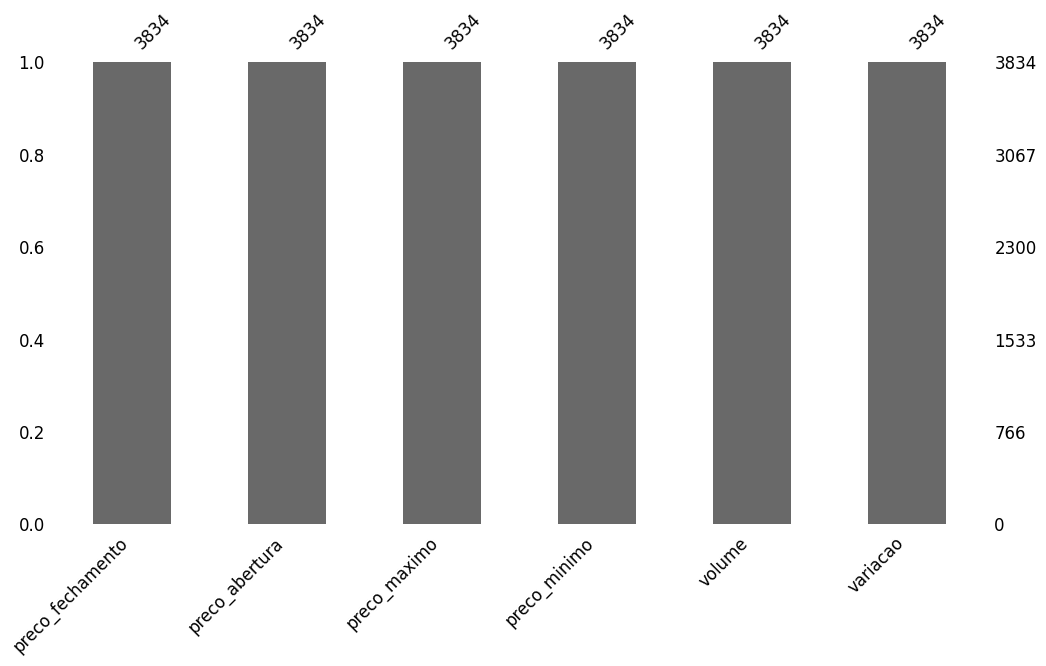

In [22]:
#Verificando a quantidade de dados faltantes através do missingno
#O gráfico de barras gerado pela biblioteca missingno visualiza a completude dos dados em cada coluna do DataFrame. 
#A altura de cada barra representa a proporção de valores não-nulos. Observamos que todas as colunas possuem barras com altura máxima, 
#confirmando que nosso DataFrame, com 3834 registros, não contém dados faltantes após as etapas de pré-processamento.
msno.bar(df_ibovespa, figsize=(12, 6), fontsize=12)

In [23]:
#Como ficou nosso DataFrame após as conversões
print("\nInformações do DataFrame após as mudanças:")
df_ibovespa.info()
print("=" * 35)


Informações do DataFrame após as mudanças:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2015-01-19 to 2025-07-18
Freq: D
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   preco_fechamento  3834 non-null   float64
 1   preco_abertura    3834 non-null   float64
 2   preco_maximo      3834 non-null   float64
 3   preco_minimo      3834 non-null   float64
 4   volume            3834 non-null   int64  
 5   variacao          3834 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 209.7 KB


In [24]:
df_ibovespa.describe().T

,count,mean,std,min,25%,50%,75%,max
preco_fechamento,3834.0,9.433724e+01,2.764750e+01,37.497,7.017575e+01,1.015185e+02,1.171540e+02,1.412640e+02
preco_abertura,3834.0,9.432307e+01,2.765996e+01,37.501,7.007700e+01,1.014600e+02,1.170250e+02,1.412650e+02
preco_maximo,3834.0,9.513995e+01,2.776491e+01,38.031,7.139775e+01,1.023295e+02,1.181218e+02,1.415640e+02
preco_minimo,3834.0,9.350728e+01,2.753093e+01,37.046,6.914175e+01,1.005260e+02,1.160280e+02,1.405970e+02
volume,3834.0,5.413098e+08,2.438331e+09,424320.000,3.862500e+06,7.310000e+06,1.121000e+07,2.487000e+10
variacao,3834.0,3.061555e-02,1.469351e+00,-14.780,-7.500000e-01,5.000000e-02,8.300000e-01,1.391000e+01


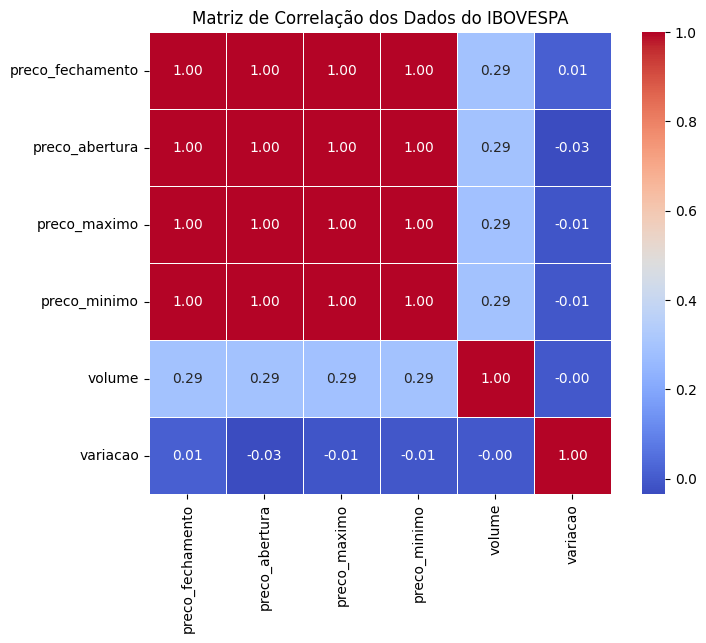

In [25]:
#Correlação entre os dados utilizando o metodo person
#O método Pearson é usado para medir a correlação linear entre duas variáveis, assumindo que ambas são normalmente distribuídas. 
#Ele calcula o coeficiente de correlação, que varia de -1 a 1, onde 1 indica uma correlação positiva perfeita, -1 indica uma correlação negativa perfeita e 0 indica nenhuma correlação linear.
correlation_matrix = df_ibovespa.corr(method='pearson')

plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Matriz de Correlação dos Dados do IBOVESPA')
plt.show()

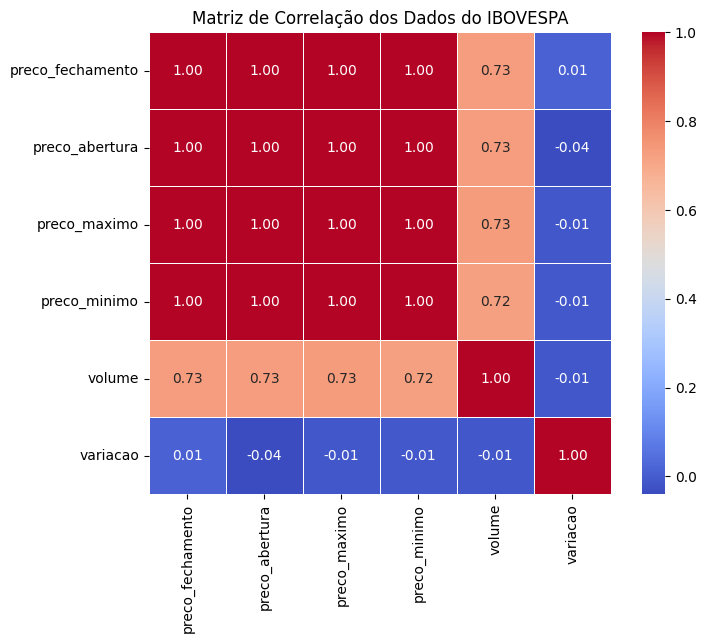

In [26]:
#Correlação entre os dados utilizando o metodo Spearman
#O método Spearman é usado para medir a correlação entre duas variáveis, considerando a relação monotônica entre elas, ou seja, se uma variável aumenta, a outra também tende a aumentar ou diminuir, independentemente de sua distribuição.
correlation_matrix = df_ibovespa.corr(method='spearman')

plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Matriz de Correlação dos Dados do IBOVESPA')
plt.show()

<Figure size 1200x1200 with 0 Axes>

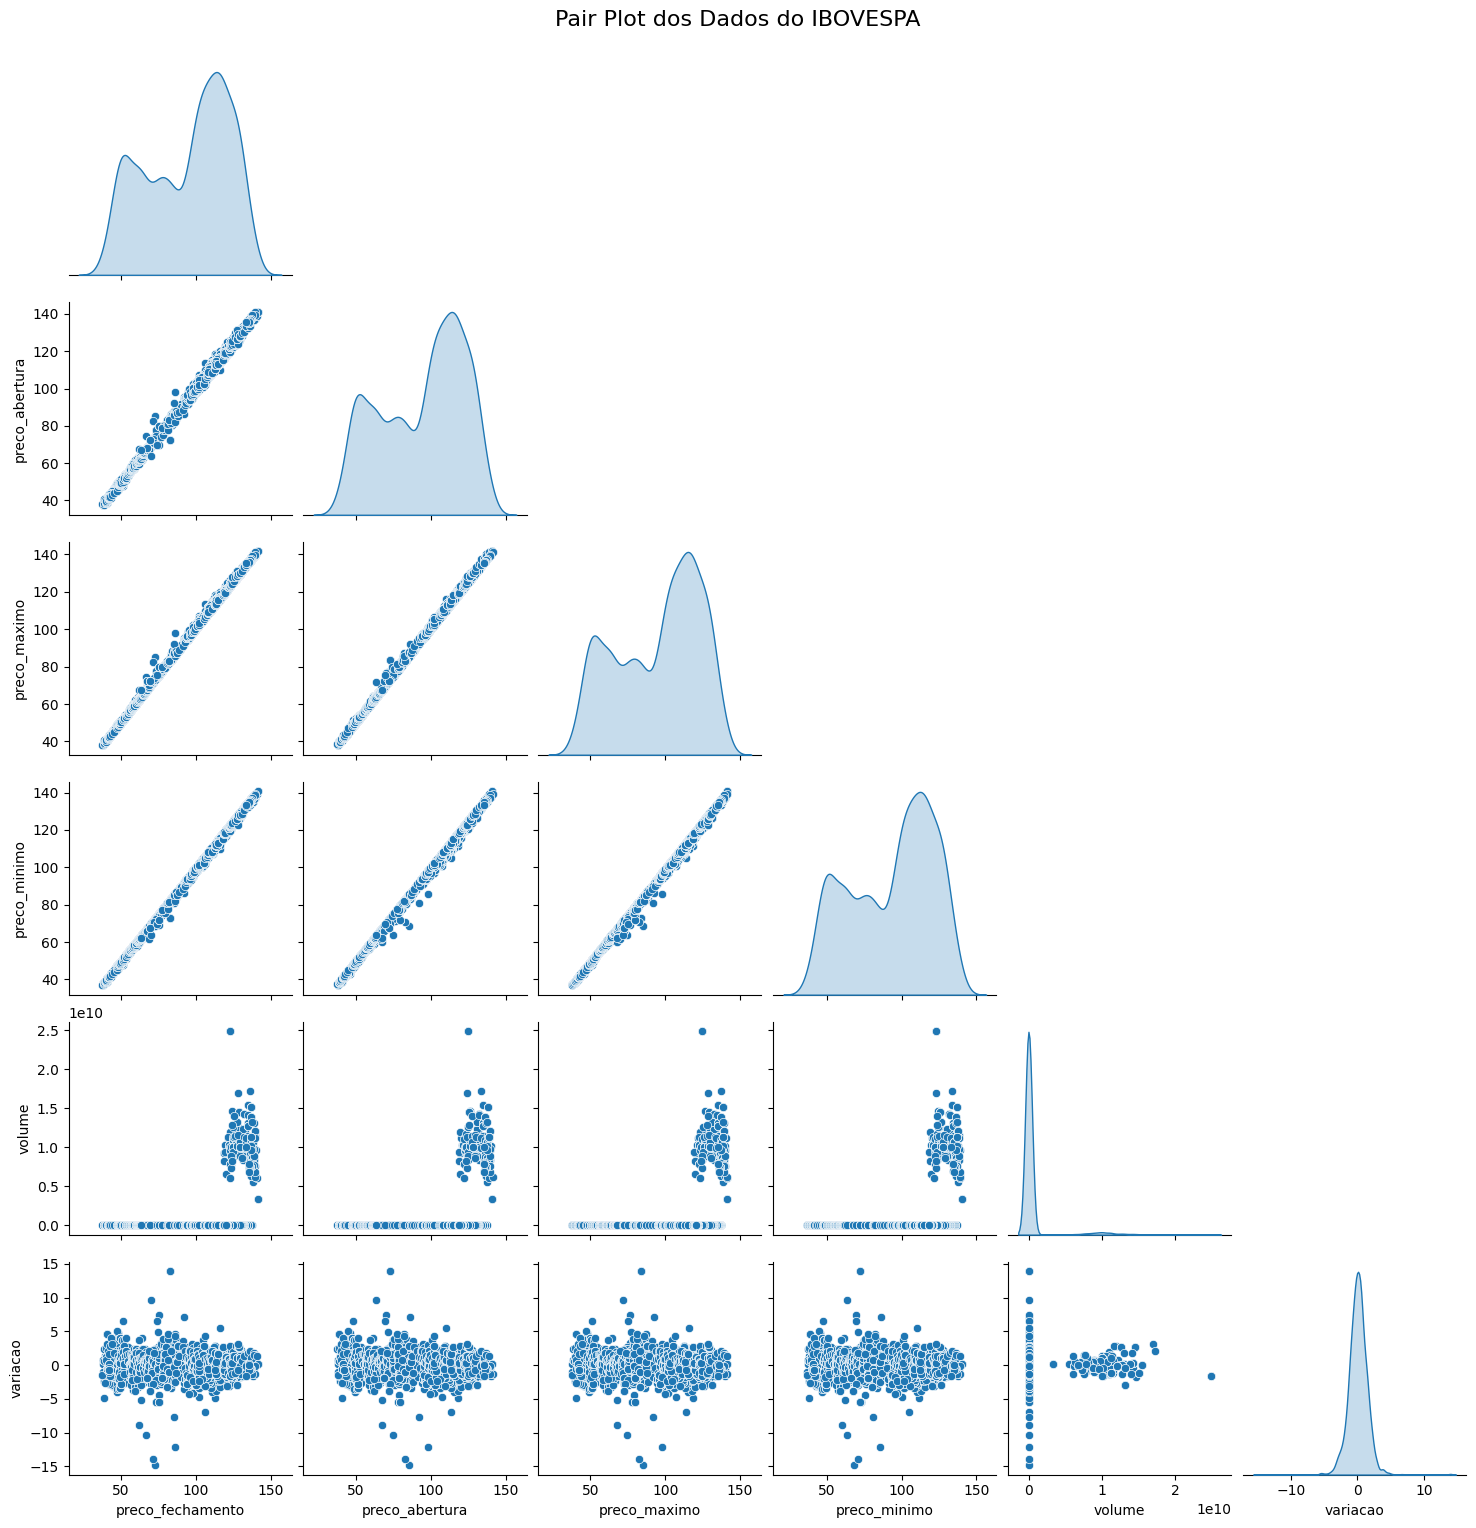

In [27]:
#Usando pair plot para visualizar a relação entre as variáveis
#O pair plot é uma ferramenta útil para explorar visualmente a relação entre múltiplas variáveis. 
#Ele cria gráficos de dispersão para cada par de variáveis, permitindo identificar padrões, tendências e possíveis correlações entre elas.
plt.figure(figsize=(12, 12))
sb.pairplot(df_ibovespa, diag_kind='kde', corner=True)
plt.suptitle('Pair Plot dos Dados do IBOVESPA', y=1.02, fontsize=16)
plt.show()

array([[<Axes: title={'center': 'preco_fechamento'}>,
        <Axes: title={'center': 'preco_abertura'}>],
       [<Axes: title={'center': 'preco_maximo'}>,
        <Axes: title={'center': 'preco_minimo'}>],
       [<Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'variacao'}>]], dtype=object)

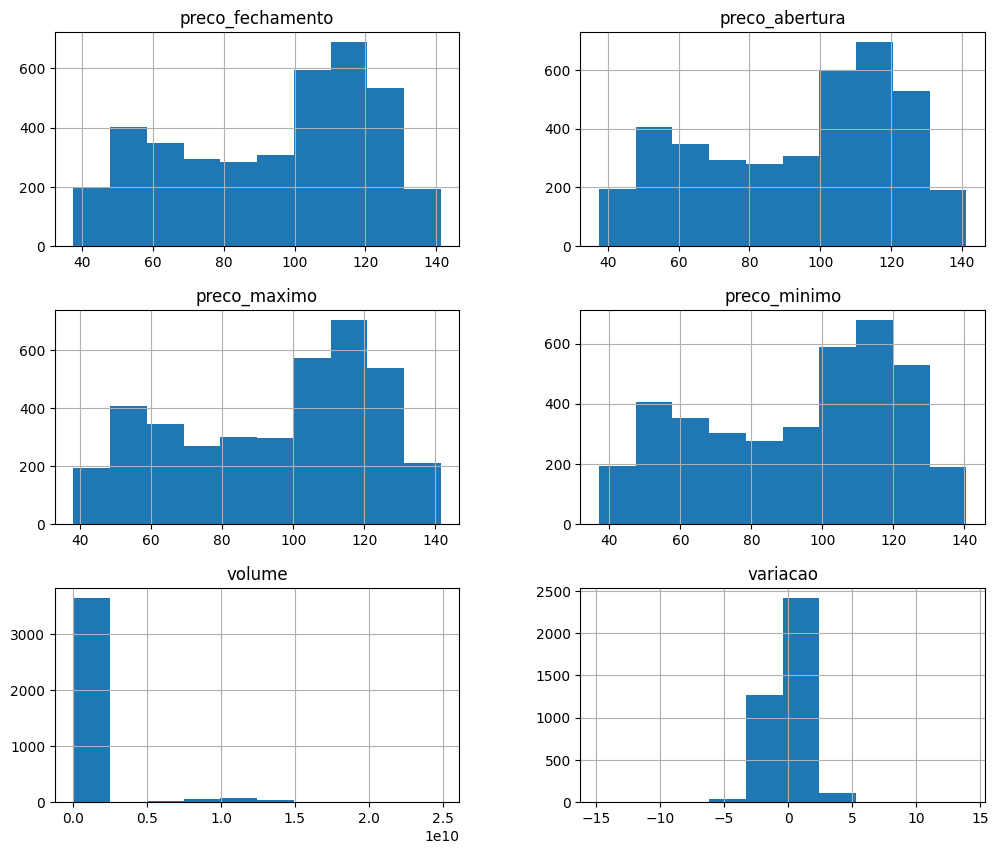

In [28]:
#Plotando o histograma para verificarmos a frequência de cada variável
df_ibovespa.hist(figsize=(12,10))

In [ ]:
#Criando a varável tendência que será nossa variável target.
#Sendo derivada a coluna preco_fechamento_proximo_dia aplicando .shift(-1) sobre a variável preco_fechamento.
df_ibovespa['preco_fechamento_proximo_dia'] = df_ibovespa['preco_fechamento'].shift(-1)
df_ibovespa['tendencia'] = (df_ibovespa['preco_fechamento_proximo_dia'] > df_ibovespa['preco_fechamento']).astype(int)

In [ ]:
#Criando uma nova feature chamada amplitude_diaria que da contexto a volatividade do dia.
df_ibovespa['amplitude_diaria'] = df_ibovespa['preco_maximo'] - df_ibovespa['preco_minimo']

In [31]:
df_ibovespa.head()

,preco_fechamento,preco_abertura,preco_maximo,preco_minimo,volume,variacao,preco_fechamento_proximo_dia,tendencia,amplitude_diaria
data_pregao,,,,,,,,,
2015-01-19,47.758,49.009,49.009,47.503,2100000,-2.57,47.877,1,1.506
2015-01-20,47.877,47.759,48.687,47.619,2900000,0.25,49.224,1,1.068
2015-01-21,49.224,47.888,49.329,47.888,3560000,2.81,49.443,1,1.441
2015-01-22,49.443,49.227,50.281,49.227,4950000,0.44,48.775,0,1.054
2015-01-23,48.775,49.432,49.523,48.496,3080000,-1.35,48.775,0,1.027


In [32]:
df_ibovespa.dropna(subset=['preco_fechamento_proximo_dia'], inplace=True)
df_ibovespa.tail()

,preco_fechamento,preco_abertura,preco_maximo,preco_minimo,volume,variacao,preco_fechamento_proximo_dia,tendencia,amplitude_diaria
data_pregao,,,,,,,,,
2025-07-13,136.187,136.742,136.742,135.528,7400000000,-0.41,135.299,0,1.214
2025-07-14,135.299,136.187,136.187,134.840,7330000000,-0.65,135.250,0,1.347
2025-07-15,135.250,135.298,136.022,134.380,6900000000,-0.04,135.511,1,1.642
2025-07-16,135.511,135.250,135.641,134.265,7830000000,0.19,135.565,1,1.376
2025-07-17,135.565,135.515,135.792,135.016,6800000000,0.04,133.382,0,0.776


In [33]:
df_ibovespa['tendencia'] = df_ibovespa['tendencia'].astype('category')
print("\nContagem de classes da Variável Target 'tendencia':")
df_ibovespa['tendencia'].value_counts()


Contagem de classes da Variável Target 'tendencia':


tendencia
0    2478
1    1355
Name: count, dtype: int64

In [34]:
print("\nVerificação final de dados nulos na coluna tendência:")
print(df_ibovespa['tendencia'].isnull().sum())


Verificação final de dados nulos na coluna tendência:
0


In [35]:
#Gerando a descrição estatística do DataFrame, visualizar as principais estatísticas de cada coluna pode nos trazer insights sobre a distribuição dos dados, 
#como média, desvio padrão, valores mínimo e máximo, entre outros.
print("\nDescrição estatística do DataFrame:")
df_ibovespa.describe().T


Descrição estatística do DataFrame:


,count,mean,std,min,25%,50%,75%,max
preco_fechamento,3833.0,9.432705e+01,2.764391e+01,37.497,70.075,101.516,1.171210e+02,1.412640e+02
preco_abertura,3833.0,9.431231e+01,2.765555e+01,37.501,70.077,101.460,1.170250e+02,1.412650e+02
preco_maximo,3833.0,9.512940e+01,2.776085e+01,38.031,71.390,102.328,1.180820e+02,1.415640e+02
preco_minimo,3833.0,9.349690e+01,2.752702e+01,37.046,69.069,100.526,1.160130e+02,1.405970e+02
volume,3833.0,5.388238e+08,2.433785e+09,424320.000,3860000.000,7310000.000,1.121000e+07,2.487000e+10
variacao,3833.0,3.104357e-02,1.469303e+00,-14.780,-0.750,0.050,8.300000e-01,1.391000e+01
preco_fechamento_proximo_dia,3833.0,9.434939e+01,2.764087e+01,37.497,70.478,101.521,1.171650e+02,1.412640e+02
amplitude_diaria,3833.0,1.632505e+00,9.935307e-01,0.270,1.011,1.424,2.000000e+00,1.661500e+01


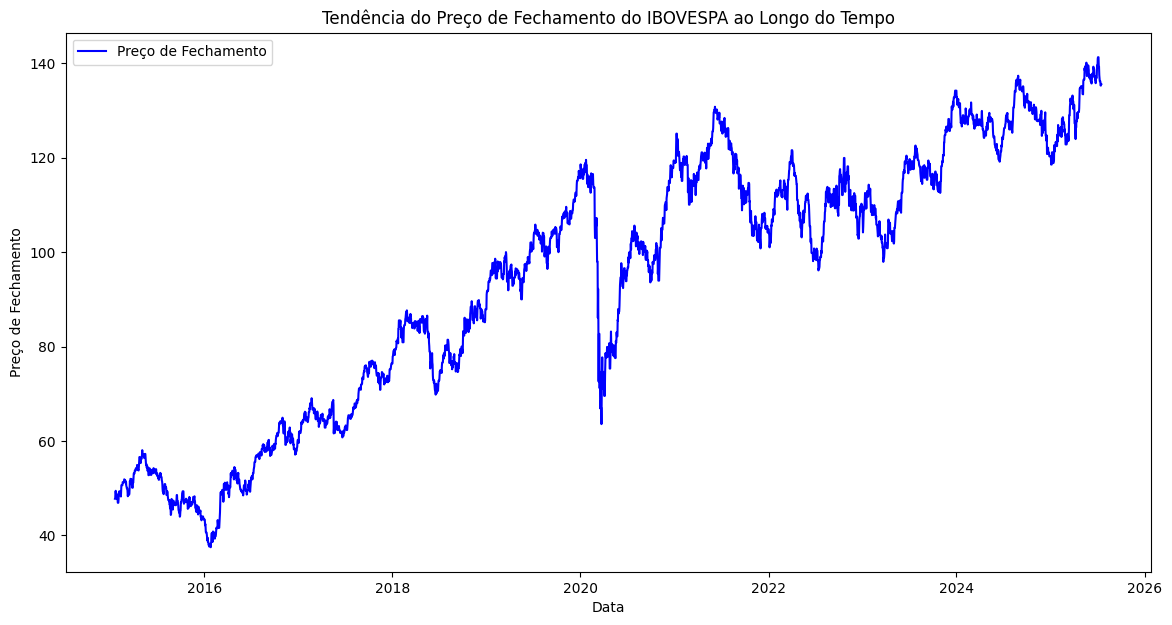

In [36]:
#Gerando o gráfico de linha para visualizar a tendência do preço de fechamento ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(df_ibovespa.index, df_ibovespa['preco_fechamento'], label='Preço de Fechamento', color='blue')
plt.title('Tendência do Preço de Fechamento do IBOVESPA ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

<Figure size 1200x1200 with 0 Axes>

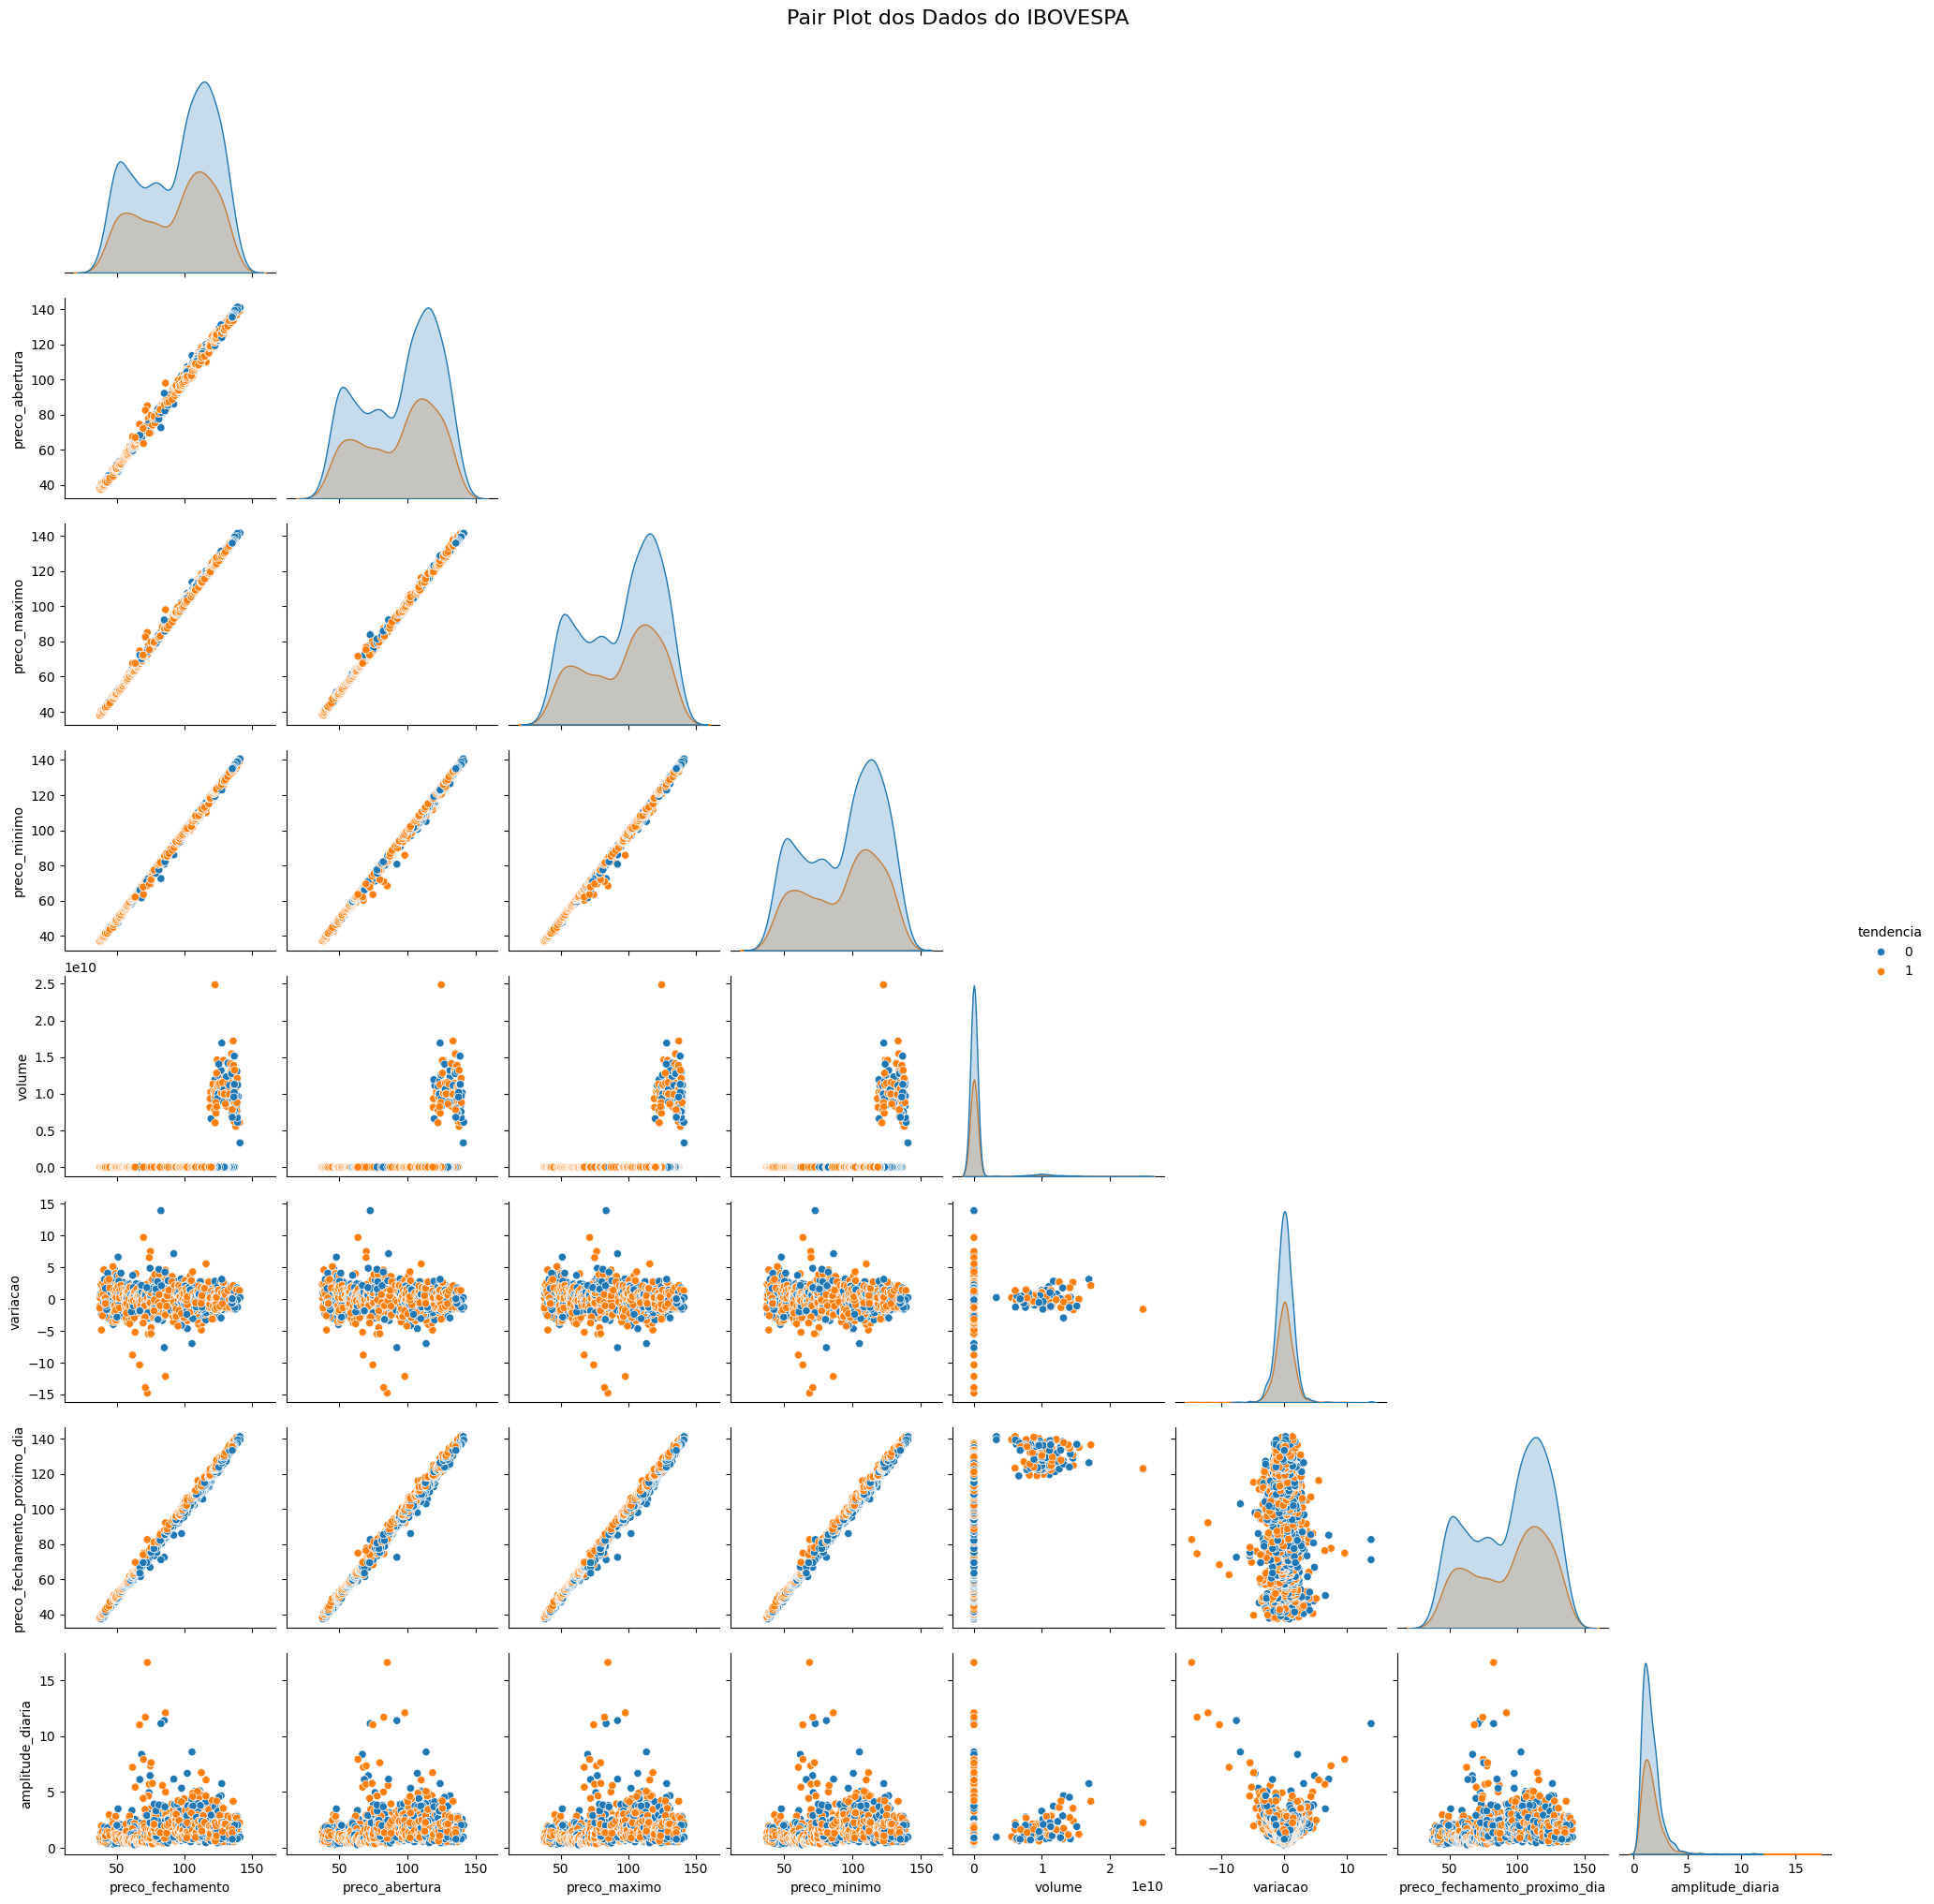

In [38]:
#Usando pair plot para visualizar a relação entre as variáveis
plt.figure(figsize=(12, 12))
sb.pairplot(df_ibovespa, diag_kind='kde', corner=True, hue='tendencia')
plt.suptitle('Pair Plot dos Dados do IBOVESPA', y=1.02, fontsize=16)
plt.show()

## **5. Desenvolvimento do modelo de treinamento**

In [39]:
#Criando lags features para preco_fechamento, variacao e volume
#As lags features são importantes para capturar a dependência temporal dos dados, permitindo que o modelo aprenda padrões históricos e faça previsões mais precisas. 
#Elas são especialmente úteis em séries temporais, onde o valor atual pode depender de valores passados.
for i in range(1, 6):
    df_ibovespa[f'preco_fechamento_lag{i}'] = df_ibovespa['preco_fechamento'].shift(i)
    df_ibovespa[f'variacao_lag{i}'] = df_ibovespa['variacao'].shift(i)
    df_ibovespa[f'volume_lag{i}'] = df_ibovespa['volume'].shift(i)


In [ ]:
#Calculo de Retornos Diários (logarítmicos ou percentuais) e seus lags.
#Os retornos diários são uma métrica importante para avaliar a performance de um ativo financeiro.
df_ibovespa['retorno_pct'] = df_ibovespa['preco_fechamento'].pct_change() * 100
for i in range(1, 6):
    df_ibovespa[f'retorno_pct_lag{i}'] = df_ibovespa['retorno_pct'].shift(i)

#As médias móveis simples é um indicador técnico usado para suavizar os dados de preços e identificar tendências de longo prazo, elas ajudam a filtrar o "ruído" das flutuações diárias.
#É calculada somando os preços de fechamento de um ativo durante um número especifico de dias, em seguida dividindo o total pelo número de dias.
df_ibovespa['SMA_10'] = df_ibovespa['preco_fechamento'].rolling(window=10).mean()
df_ibovespa['SMA_20'] = df_ibovespa['preco_fechamento'].rolling(window=20).mean()
df_ibovespa['SMA_50'] = df_ibovespa['preco_fechamento'].rolling(window=50).mean()
df_ibovespa['SMA_10_vs_20'] = df_ibovespa['SMA_10'] - df_ibovespa['SMA_20']
df_ibovespa['SMA_20_vs_50'] = df_ibovespa['SMA_20'] - df_ibovespa['SMA_50']

#Calculo da Amplitude Diária e seus lags.
#A amplitude diária é a diferença entre o preço máximo e mínimo do dia, com ela podemos medir a volatilidade de um ativo.
df_ibovespa['amplitude_diaria'] = df_ibovespa['preco_maximo'] - df_ibovespa['preco_minimo']
for i in range(1, 6): #Lags de 1 a 5 dias para a amplitude
    df_ibovespa[f'amplitude_diaria_lag{i}'] = df_ibovespa['amplitude_diaria'].shift(i)



In [41]:
#RSI é um indicador técnico, focado no momentum do preço.
#Ele mede a velocidade e a mudança dos movimentos do preços.
#Ele calcula a média de ganhos e a média de perdas durante um período, o mais comum 14, depois é normalizado para uma escala de 0 a 100
period_rsi = 14

#Calcula as mudanças diárias no preço de fechamento
delta = df_ibovespa['preco_fechamento'].diff(1)

#Separando em Ganhos (Gains) e Perdas (Losses)
gains = delta.where(delta > 0, 0)
losses = -delta.where(delta < 0, 0)

#Calcula a Média Móvel Exponencial (EMA) dos Ganhos e Perdas
avg_gains = gains.ewm(span=period_rsi, adjust=False).mean()
avg_losses = losses.ewm(span=period_rsi, adjust=False).mean()

#Para evitar divisão por zero:
#np.inf é usado para representar infinito quando avg_losses é 0, evitando erros de divisão.
rs = np.where(avg_losses == 0, np.inf, avg_gains / avg_losses)

#Calcular o RSI
df_ibovespa['RSI'] = 100 - (100 / (1 + rs))

In [ ]:
#MACD (Convergência Divergência de Médias Móveis) é indicador técnico de momentum, ele compara a relação entre duas médias móveis exponenciais.
#Revelando mudança na força e direção da tendência.
fast_period = 12
slow_period = 26
signal_period = 9

#Calcula a EMA Rápida
df_ibovespa['EMA_Fast'] = df_ibovespa['preco_fechamento'].ewm(span=fast_period, adjust=False).mean()

# Calcula a EMA Lenta
df_ibovespa['EMA_Slow'] = df_ibovespa['preco_fechamento'].ewm(span=slow_period, adjust=False).mean()

#Calcula a Linha MACD
df_ibovespa['MACD'] = df_ibovespa['EMA_Fast'] - df_ibovespa['EMA_Slow']

#Calcula a Linha de Sinal (EMA do MACD)
df_ibovespa['MACD_signal'] = df_ibovespa['MACD'].ewm(span=signal_period, adjust=False).mean()

#Calcula o Histograma do MACD. O histograma mostra aceleração ou desaceleração do momentum
df_ibovespa['MACD_hist'] = df_ibovespa['MACD'] - df_ibovespa['MACD_signal']

#Remove as colunas auxiliares (opcional, para manter o DataFrame limpo)
df_ibovespa.drop(columns=['EMA_Fast', 'EMA_Slow'], inplace=True, errors='ignore')

In [43]:
#ATR é um indicador técnico que mede a volatilidade de mercado, um complemento aos indicadores de tendência como Médias móveis e momentum (RSI, MACD)
#Ele não indica a direção do preço (subir ou descer), mas sim o quanto o preço tende a se mover.
atr_period = 14

#Calcula o True Range (TR) para cada dia
high_low = df_ibovespa['preco_maximo'] - df_ibovespa['preco_minimo']
high_prev_close = abs(df_ibovespa['preco_maximo'] - df_ibovespa['preco_fechamento'].shift(1))
low_prev_close = abs(df_ibovespa['preco_minimo'] - df_ibovespa['preco_fechamento'].shift(1))

#Usa numpy.maximum para encontrar o máximo entre as três séries
df_ibovespa['TR'] = np.maximum(high_low, np.maximum(high_prev_close, low_prev_close))

#Calcula o ATR (EMA do TR)
df_ibovespa['ATR'] = df_ibovespa['TR'].ewm(span=atr_period, adjust=False).mean()

#Removendo a coluna auxiliar TR (é opcional)
df_ibovespa.drop(columns=['TR'], inplace=True, errors='ignore')

In [44]:
df_ibovespa.dropna(inplace=True)

In [45]:
df_ibovespa.head()

,preco_fechamento,preco_abertura,preco_maximo,preco_minimo,volume,variacao,preco_fechamento_proximo_dia,tendencia,amplitude_diaria,preco_fechamento_lag1,...,amplitude_diaria_lag1,amplitude_diaria_lag2,amplitude_diaria_lag3,amplitude_diaria_lag4,amplitude_diaria_lag5,RSI,MACD,MACD_signal,MACD_hist,ATR
data_pregao,,,,,,,,,,,,,,,,,,,,,
2015-03-09,49.181,49.978,49.978,48.952,3300000,-1.60,48.293,0,1.026,49.981,...,0.622,0.622,0.622,0.620,0.904,16.595956,0.001235,0.331698,-0.330463,0.795612
2015-03-10,48.293,49.177,49.177,48.293,4430000,-1.81,48.906,1,0.884,49.181,...,1.026,0.622,0.622,0.622,0.620,11.315684,-0.166725,0.232014,-0.398738,0.807931
2015-03-11,48.906,48.309,48.937,48.309,3840000,1.27,48.880,0,0.628,48.293,...,0.884,1.026,0.622,0.622,0.622,29.246412,-0.247517,0.136107,-0.383624,0.786073
2015-03-12,48.880,48.908,49.633,48.684,3830000,-0.05,48.596,0,0.949,48.906,...,0.628,0.884,1.026,0.622,0.622,28.959857,-0.310069,0.046872,-0.356941,0.807797
2015-03-13,48.596,48.858,48.858,47.905,4480000,-0.58,48.596,0,0.953,48.880,...,0.949,0.628,0.884,1.026,0.622,25.776714,-0.378198,-0.038142,-0.340057,0.830091


In [46]:
df_ibovespa.shape

(3784, 45)

In [47]:
df_ibovespa.isnull().sum()

preco_fechamento                0
preco_abertura                  0
preco_maximo                    0
preco_minimo                    0
volume                          0
variacao                        0
preco_fechamento_proximo_dia    0
tendencia                       0
amplitude_diaria                0
preco_fechamento_lag1           0
variacao_lag1                   0
volume_lag1                     0
preco_fechamento_lag2           0
variacao_lag2                   0
volume_lag2                     0
preco_fechamento_lag3           0
variacao_lag3                   0
volume_lag3                     0
preco_fechamento_lag4           0
variacao_lag4                   0
volume_lag4                     0
preco_fechamento_lag5           0
variacao_lag5                   0
volume_lag5                     0
retorno_pct                     0
retorno_pct_lag1                0
retorno_pct_lag2                0
retorno_pct_lag3                0
retorno_pct_lag4                0
retorno_pct_la

In [48]:
#Definindo as features que serão utilizadas no modelo.
#As features base são as variáveis que serão usadas diretamente no modelo, sem transformação adicional.
features_base_final = [
    'volume',
    'variacao',
    'amplitude_diaria',
]

#Definindo as lags features.
#As lags Features são memórias de uma série temporal de períodos anteriores, com elas criamos memórias do passado ajudando o modelo de ML a enxergar os dados anteriores.
lag_features_final = []
for i in range(1, 6):
    lag_features_final.append(f'preco_fechamento_lag{i}')
    lag_features_final.append(f'variacao_lag{i}')
    lag_features_final.append(f'volume_lag{i}')
    lag_features_final.append(f'retorno_pct_lag{i}')
    lag_features_final.append(f'amplitude_diaria_lag{i}')

#Novas features técnicas
#As novas features técnicas são criadas para capturar padrões e tendências nos dados, ajudando o modelo a aprender melhor as relações entre as variáveis e a prever a tendência futura do preço de fechamento.
novas_features_tecnicas_final = [
    'retorno_pct',
    'SMA_10', 'SMA_20', 'SMA_50',
    'SMA_10_vs_20', 'SMA_20_vs_50',
    'RSI',
    'MACD', 'MACD_signal', 'MACD_hist',
    'ATR',
]

features_para_o_modelo = features_base_final + lag_features_final + novas_features_tecnicas_final
target_coluna = 'tendencia'

print(f"\nFeatures que serão usadas no modelo ({len(features_para_o_modelo)} no total):")
print(features_para_o_modelo)
print("-" * 50)



Features que serão usadas no modelo (39 no total):
['volume', 'variacao', 'amplitude_diaria', 'preco_fechamento_lag1', 'variacao_lag1', 'volume_lag1', 'retorno_pct_lag1', 'amplitude_diaria_lag1', 'preco_fechamento_lag2', 'variacao_lag2', 'volume_lag2', 'retorno_pct_lag2', 'amplitude_diaria_lag2', 'preco_fechamento_lag3', 'variacao_lag3', 'volume_lag3', 'retorno_pct_lag3', 'amplitude_diaria_lag3', 'preco_fechamento_lag4', 'variacao_lag4', 'volume_lag4', 'retorno_pct_lag4', 'amplitude_diaria_lag4', 'preco_fechamento_lag5', 'variacao_lag5', 'volume_lag5', 'retorno_pct_lag5', 'amplitude_diaria_lag5', 'retorno_pct', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_10_vs_20', 'SMA_20_vs_50', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'ATR']
--------------------------------------------------


In [49]:
features_para_o_modelo

['volume',
 'variacao',
 'amplitude_diaria',
 'preco_fechamento_lag1',
 'variacao_lag1',
 'volume_lag1',
 'retorno_pct_lag1',
 'amplitude_diaria_lag1',
 'preco_fechamento_lag2',
 'variacao_lag2',
 'volume_lag2',
 'retorno_pct_lag2',
 'amplitude_diaria_lag2',
 'preco_fechamento_lag3',
 'variacao_lag3',
 'volume_lag3',
 'retorno_pct_lag3',
 'amplitude_diaria_lag3',
 'preco_fechamento_lag4',
 'variacao_lag4',
 'volume_lag4',
 'retorno_pct_lag4',
 'amplitude_diaria_lag4',
 'preco_fechamento_lag5',
 'variacao_lag5',
 'volume_lag5',
 'retorno_pct_lag5',
 'amplitude_diaria_lag5',
 'retorno_pct',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'SMA_10_vs_20',
 'SMA_20_vs_50',
 'RSI',
 'MACD',
 'MACD_signal',
 'MACD_hist',
 'ATR']

In [50]:
#Dividindo o período que deve ser considerado para treino e teste.
data_corte = df_ibovespa.index.max() - pd.Timedelta(days=30)

df_ibovespa_treino = df_ibovespa[df_ibovespa.index <= data_corte].copy()
df_ibovespa_teste = df_ibovespa[df_ibovespa.index > data_corte].copy()


In [51]:
df_ibovespa_treino

,preco_fechamento,preco_abertura,preco_maximo,preco_minimo,volume,variacao,preco_fechamento_proximo_dia,tendencia,amplitude_diaria,preco_fechamento_lag1,...,amplitude_diaria_lag1,amplitude_diaria_lag2,amplitude_diaria_lag3,amplitude_diaria_lag4,amplitude_diaria_lag5,RSI,MACD,MACD_signal,MACD_hist,ATR
data_pregao,,,,,,,,,,,,,,,,,,,,,
2015-03-09,49.181,49.978,49.978,48.952,3300000,-1.60,48.293,0,1.026,49.981,...,0.622,0.622,0.622,0.620,0.904,16.595956,0.001235,0.331698,-0.330463,0.795612
2015-03-10,48.293,49.177,49.177,48.293,4430000,-1.81,48.906,1,0.884,49.181,...,1.026,0.622,0.622,0.622,0.620,11.315684,-0.166725,0.232014,-0.398738,0.807931
2015-03-11,48.906,48.309,48.937,48.309,3840000,1.27,48.880,0,0.628,48.293,...,0.884,1.026,0.622,0.622,0.622,29.246412,-0.247517,0.136107,-0.383624,0.786073
2015-03-12,48.880,48.908,49.633,48.684,3830000,-0.05,48.596,0,0.949,48.906,...,0.628,0.884,1.026,0.622,0.622,28.959857,-0.310069,0.046872,-0.356941,0.807797
2015-03-13,48.596,48.858,48.858,47.905,4480000,-0.58,48.596,0,0.953,48.880,...,0.949,0.628,0.884,1.026,0.622,25.776714,-0.378198,-0.038142,-0.340057,0.830091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13,137.213,137.800,137.800,136.586,8630000000,-0.43,137.213,0,1.214,137.800,...,1.756,1.903,1.653,1.987,1.289,53.813569,-0.004808,0.038917,-0.043725,1.633755
2025-06-14,137.213,137.800,137.800,136.586,8630000000,-0.43,137.213,0,1.214,137.213,...,1.214,1.756,1.903,1.653,1.987,53.813569,0.017632,0.034660,-0.017028,1.577788
2025-06-15,137.213,137.800,137.800,136.586,8630000000,-0.43,139.256,1,1.214,137.213,...,1.214,1.214,1.756,1.903,1.653,53.813569,0.035012,0.034731,0.000281,1.529283


In [ ]:
#Extraindo as features e a variável target para treino e teste.
X_train = df_ibovespa_treino[features_para_o_modelo]
y_train = df_ibovespa_treino[target_coluna]

X_test = df_ibovespa_teste[features_para_o_modelo]
y_test = df_ibovespa_teste[target_coluna]

### **Treinando o modelo XGBoost**

In [ ]:
#Padronização das features, garantindo que tenham média de 0 e desvio padrão de 1, deixando-as com a mesma escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
len(X_train_scaled), len(X_test_scaled)

(3754, 30)

In [55]:
X_train_scaled

array([[-2.05526200e-01, -1.10731476e+00, -6.16939637e-01, ...,
         1.41268758e-01, -9.44051995e-01, -1.13250317e+00],
       [-2.05050314e-01, -1.24971546e+00, -7.59017879e-01, ...,
         5.83544600e-02, -1.13928263e+00, -1.11602605e+00],
       [-2.05298785e-01,  8.38828181e-01, -1.01515893e+00, ...,
        -2.14169858e-02, -1.09606419e+00, -1.14526276e+00],
       ...,
       [ 3.42750707e+00, -3.13939414e-01, -4.28836050e-01, ...,
        -1.05738739e-01,  1.70519105e-03, -1.51139018e-01],
       [ 3.00215744e+00,  9.88009870e-01,  1.13402461e+00, ...,
        -7.63817806e-02,  4.04598226e-01,  7.12103640e-02],
       [ 3.32222251e+00, -2.25786598e-01, -4.38841560e-01, ...,
        -3.58532801e-02,  5.58221959e-01, -1.64497196e-02]],
      shape=(3754, 39))

In [ ]:
#O 'scale_pos_weight' é um parâmetro específico do XGBoost (e outros modelos baseados em árvores)
#que serve para ajustar o peso da classe positiva (minoritária) durante o treinamento.
#Ele penaliza mais severamente os erros de classificação da classe minoritária, forçando o algoritmo
#a dar mais atenção e aprender a identificar corretamente esses eventos mais raros.
#Isso é crucial para problemas de desbalanceamento, onde a classe majoritária dominaria
#o aprendizado se não houvesse esse ajuste de peso.
count_neg = y_train.value_counts()[0]
count_pos = y_train.value_counts()[1]
scale_pos_weight_value = count_neg / count_pos
print(f"scale_pos_weight para XGBoost: {scale_pos_weight_value:.2f}")

#Definindo o modelo base do XGBoost com o scale_pos_weight
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight_value, random_state=42)



scale_pos_weight para XGBoost: 1.82


In [59]:
#A validação cruzada é uma técnica fundamental para avaliar a performance de um modelo de forma robusta e evitar overfitting.
#No contexto de otimização de modelos, o GridSearchCV é uma ferramenta que utiliza a validação cruzada para encontrar, 
#de forma automatizada e exaustiva, a melhor combinação de hiperparâmetros para o treinamento do modelo.
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.02, 0.05 ,0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    }


#A escolha do método de validação cruzada é crucial para a confiabilidade dos resultados.
#Dado que nosso conjunto de dados é uma série temporal e exige que a ordem cronológica dos eventos seja rigorosamente obedecida,
#a escolha pelo TimeSeriesSplit foi essencial para garantir uma avaliação realista e evitar vazamento de dados.
tscv = TimeSeriesSplit(n_splits=5)

#Configurando o GridSearchCV
#scoring pode ser 'f1' ou 'recall' para focar na classe 1
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=tscv, scoring='f1', verbose=2, n_jobs=-1)

print("\nIniciando Grid Search para XGBoost com novas features e TimeSeriesSplit...")
grid_search.fit(X_train_scaled, y_train)

print("\nGrid Search para XGBoost concluído.")
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
print(f"Melhor F1-Score no CV: {grid_search.best_score_:.4f}")

#Avaliação do melhor modelo no conjunto de teste final
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

print("\n--- Avaliação do Melhor Modelo XGBoost no Conjunto de Teste ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precisão (Classe 1): {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall (Classe 1): {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score (Classe 1): {f1_score(y_test, y_pred_xgb):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_xgb))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_xgb))


Iniciando Grid Search para XGBoost com novas features e TimeSeriesSplit...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Grid Search para XGBoost concluído.
Melhores hiperparâmetros: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Melhor F1-Score no CV: 0.5295

--- Avaliação do Melhor Modelo XGBoost no Conjunto de Teste ---
Acurácia: 0.6667
Precisão (Classe 1): 0.4286
Recall (Classe 1): 0.7500
F1-Score (Classe 1): 0.5455

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        22
           1       0.43      0.75      0.55         8

    accuracy                           0.67        30
   macro avg       0.65      0.69      0.64        30
weighted avg       0.76      0.67      0.69        30


Matriz de Confusão:
[[14  8]
 [ 2  6]]



--- Análise da Otimização do Limiar de Decisão ---


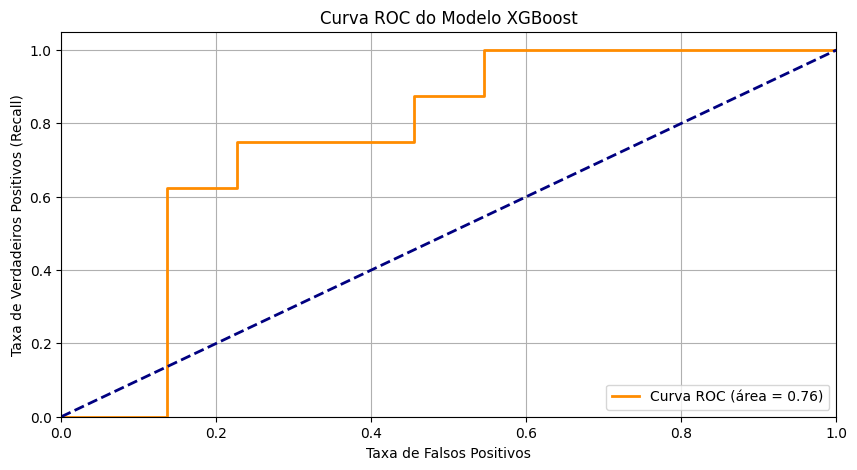

In [58]:
#Obtendo as probabilidades de previsão da classe 1 no conjunto de teste
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Análise da Otimização do Limiar de Decisão ---")

#Plot da Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC do Modelo XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

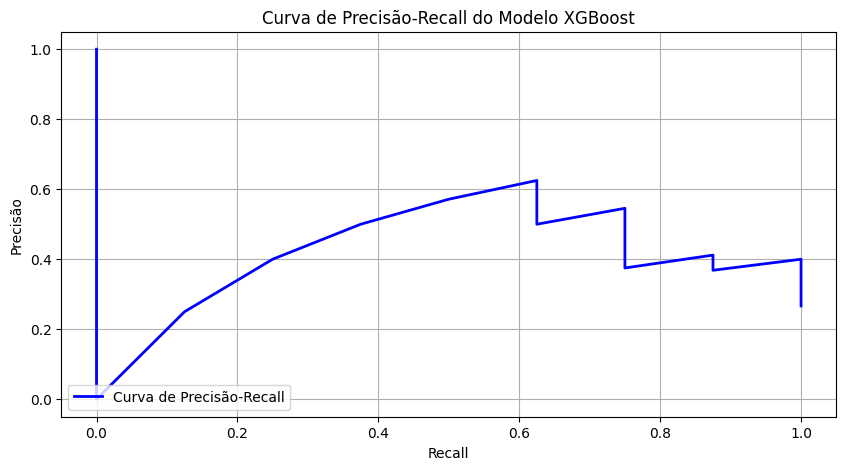

In [60]:
#Plot da Curva de Precisão-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Curva de Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Precisão-Recall do Modelo XGBoost')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [61]:
#Encontrando o melhor limiar para F1-Score
#Iteração sobre os thresholds_pr que vêm da curva de precisão-recall
#Excluímos o último threshold da lista, pois ele sempre retorna 1.0 para precision e 0.0 para recall
thresholds_for_f1_optimization = thresholds_pr[:-1] 

best_f1 = 0
best_threshold_f1 = 0.5 #Limiar padrão inicial

#Se houver amostras na lista de thresholds_for_f1_optimization para iterar
if len(thresholds_for_f1_optimization) > 0:
    for threshold in thresholds_for_f1_optimization:
        y_pred_tuned = (y_pred_proba >= threshold).astype(int)
        y_test_numeric = y_test.astype(int)

        #Evita divisão por zero se não houver previsões da classe 1 ou se não houver 1s reais
        if np.sum(y_pred_tuned) == 0 and np.sum(y_test.astype(int)) == 0:
            current_f1 = 1.0 #Perfeito se não há 1s e não previu 1s
        elif np.sum(y_pred_tuned) == 0 or np.sum(y_test.astype(int)) == 0:
            current_f1 = 0.0 #Se faltar previsões ou reais, F1 é 0
        else:
            current_f1 = f1_score(y_test, y_pred_tuned)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold_f1 = threshold
    
    print(f"\nMelhor Limiar para F1-Score (otimizado): {best_threshold_f1:.4f} (F1-Score: {best_f1:.4f})")
else:
    print("\nNão foi possível otimizar o limiar para F1-Score, pois não há thresholds suficientes ou dados para cálculo.")
    print("Mantendo o limiar padrão de 0.5 para avaliação.")


Melhor Limiar para F1-Score (otimizado): 0.5580 (F1-Score: 0.6316)


In [62]:
#Reavaliando o modelo com o melhor limiar de F1-Score encontrado
y_pred_final_f1 = (y_pred_proba >= best_threshold_f1).astype(int)

print("\n--- Avaliação do Melhor Modelo XGBoost no Conjunto de Teste (Limiar Otimizado para F1-Score) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_final_f1):.4f}")
print(f"Precisão (Classe 1): {precision_score(y_test, y_pred_final_f1):.4f}")
print(f"Recall (Classe 1): {recall_score(y_test, y_pred_final_f1):.4f}")
print(f"F1-Score (Classe 1): {f1_score(y_test, y_pred_final_f1):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_final_f1))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_final_f1))


--- Avaliação do Melhor Modelo XGBoost no Conjunto de Teste (Limiar Otimizado para F1-Score) ---
Acurácia: 0.7667
Precisão (Classe 1): 0.5455
Recall (Classe 1): 0.7500
F1-Score (Classe 1): 0.6316

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        22
           1       0.55      0.75      0.63         8

    accuracy                           0.77        30
   macro avg       0.72      0.76      0.73        30
weighted avg       0.80      0.77      0.78        30


Matriz de Confusão:
[[17  5]
 [ 2  6]]


In [63]:
best_accuracy = 0
best_threshold_accuracy = 0.5
if len(thresholds_for_f1_optimization) > 0:
    for threshold in thresholds_for_f1_optimization:
        y_pred_tuned = (y_pred_proba >= threshold).astype(int)
        current_accuracy = accuracy_score(y_test, y_pred_tuned)
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_threshold_accuracy = threshold
    print(f"\nMelhor Limiar para Acurácia (otimizado): {best_threshold_accuracy:.4f} (Acurácia: {best_accuracy:.4f})")
else:
    print("\nNão foi possível otimizar o limiar para Acurácia.")


Melhor Limiar para Acurácia (otimizado): 0.5686 (Acurácia: 0.8000)


### **Treinando o modelo Random Forest**

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf = RandomForestClassifier()
#Definição da grade de parâmetros para o Grid Search do Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],         # Número de árvores
    'max_depth': [10, 20, None],             # Profundidade máxima da árvore (None significa profundidade total)
    'min_samples_leaf': [1, 2, 4],           # Mínimo de amostras por folha
    'class_weight': ['balanced']             # Para lidar com o desbalanceamento de classes
}

#Criando o splitter para a validação cruzada temporal (ideal para sequencia temporal onde não pode haver embaralhamento de datas)
tscv = TimeSeriesSplit(n_splits=5) #O n_splits pode variar

#Configurando o GridSearchCV para o Random Forest
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), # Modelo Random Forest
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='f1', # Sugestão: 'f1' para desbalanceamento, ou 'accuracy' se preferir
    n_jobs=-1,
    verbose=1
)

print("Iniciando Grid Search para Random Forest...")

#Treinando o Grid Search para encontrar os melhores hiperparâmetros
grid_search_rf.fit(X_train_scaled, y_train)

print("\nGrid Search para Random Forest concluído.")
print(f"Melhores hiperparâmetros: {grid_search_rf.best_params_}")
print(f"Melhor F1-Score no CV: {grid_search_rf.best_score_:.4f}")

Iniciando Grid Search para Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Grid Search para Random Forest concluído.
Melhores hiperparâmetros: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 200}
Melhor F1-Score no CV: 0.2599


In [66]:
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled) #Previsões com limiar padrão (0.5)

print("\n--- Avaliação do Melhor Modelo Random Forest no Conjunto de Teste (Limiar Padrão 0.5) ---")
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)

print(f"Acurácia: {accuracy_rf:.4f}")
print(f"Precisão (Classe 1): {precision_rf:.4f}")
print(f"Recall (Classe 1): {recall_rf:.4f}")
print(f"F1-Score (Classe 1): {f1_rf:.4f}")


--- Avaliação do Melhor Modelo Random Forest no Conjunto de Teste (Limiar Padrão 0.5) ---
Acurácia: 0.7333
Precisão (Classe 1): 0.5000
Recall (Classe 1): 0.3750
F1-Score (Classe 1): 0.4286


In [67]:
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_rf))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        22
           1       0.50      0.38      0.43         8

    accuracy                           0.73        30
   macro avg       0.65      0.62      0.63        30
weighted avg       0.71      0.73      0.72        30


Matriz de Confusão:
[[19  3]
 [ 5  3]]


In [68]:
y_pred_proba_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]

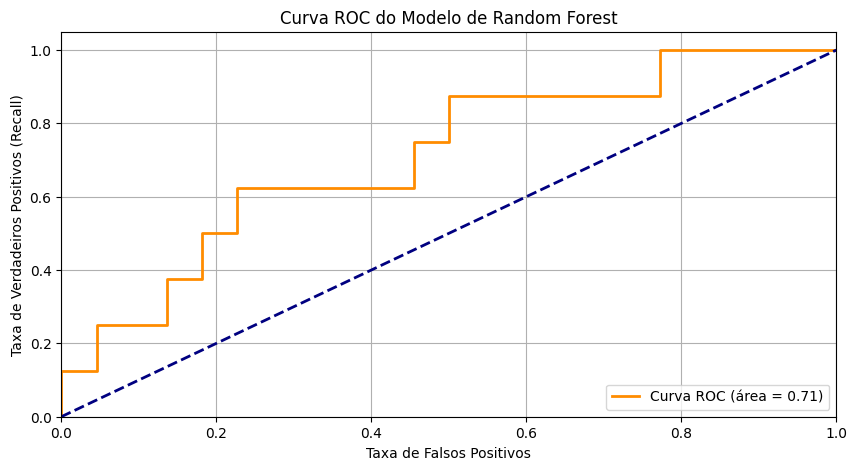

In [69]:
#Plot da Curva ROC
fpr_rf, tpr_rf, thresholds_roc_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 5))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC do Modelo de Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

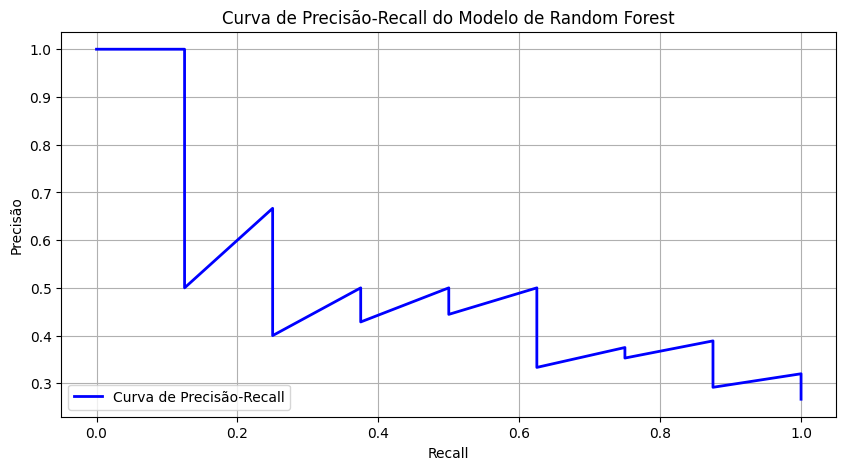

In [70]:
#Plot da Curva de Precisão-Recall
precision_rf, recall_rf, thresholds_pr_rf = precision_recall_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 5))
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label='Curva de Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Precisão-Recall do Modelo de Random Forest')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [71]:
#Encontrando o melhor limiar para F1-Score para Regressão Logística
thresholds_for_f1_optimization_rf = thresholds_pr_rf[:-1] 

best_f1_rf = 0
best_threshold_f1_rf = 0.5

if len(thresholds_for_f1_optimization_rf) > 0:
    for threshold in thresholds_for_f1_optimization_rf:
        y_pred_tuned_rf = (y_pred_proba_rf >= threshold).astype(int)
        
        #Evita divisão por zero
        if np.sum(y_pred_tuned_rf) == 0 and np.sum(y_test.astype(int)) == 0:
            current_f1_rf = 1.0
        elif np.sum(y_pred_tuned_rf) == 0 or np.sum(y_test.astype(int)) == 0:
            current_f1_rf = 0.0
        else:
            current_f1_rf = f1_score(y_test, y_pred_tuned_rf)
        
        if current_f1_rf > best_f1_rf:
            best_f1_rf = current_f1_rf
            best_threshold_f1_rf = threshold
    
    print(f"\nMelhor Limiar para F1-Score (Random Forest): {best_threshold_f1_rf:.4f} (F1-Score: {best_f1_rf:.4f})")
else:
    print("\nNão foi possível otimizar o limiar para F1-Score da Regressão Logística.")
    print("Mantendo o limiar padrão de 0.5 para avaliação.")


Melhor Limiar para F1-Score (Random Forest): 0.4657 (F1-Score: 0.5556)


In [72]:
#Reavaliando o modelo de Random Forest com o melhor limiar de F1-Score
y_pred_final_f1_rf = (y_pred_proba_rf >= best_threshold_f1_rf).astype(int)

print("\n--- Avaliação do Modelo de Random Forest (Limiar Otimizado para F1-Score) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_final_f1_rf):.4f}")
print(f"Precisão (Classe 1): {precision_score(y_test, y_pred_final_f1_rf):.4f}")
print(f"Recall (Classe 1): {recall_score(y_test, y_pred_final_f1_rf):.4f}")
print(f"F1-Score (Classe 1): {f1_score(y_test, y_pred_final_f1_rf):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_final_f1_rf))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_final_f1_rf))


--- Avaliação do Modelo de Random Forest (Limiar Otimizado para F1-Score) ---
Acurácia: 0.7333
Precisão (Classe 1): 0.5000
Recall (Classe 1): 0.6250
F1-Score (Classe 1): 0.5556

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.50      0.62      0.56         8

    accuracy                           0.73        30
   macro avg       0.68      0.70      0.68        30
weighted avg       0.76      0.73      0.74        30


Matriz de Confusão:
[[17  5]
 [ 3  5]]


In [73]:
best_accuracy_rf = 0
best_threshold_accuracy_rf = 0.5
if len(thresholds_for_f1_optimization_rf) > 0:
    for threshold in thresholds_for_f1_optimization_rf:
        y_pred_tuned_rf = (y_pred_proba_rf >= threshold).astype(int)
        current_accuracy_rf = accuracy_score(y_test, y_pred_tuned_rf)
        if current_accuracy_rf > best_accuracy_rf:
            best_accuracy_rf = current_accuracy_rf
            best_threshold_accuracy_rf = threshold
    print(f"\nMelhor Limiar para Acurácia (Random Forest): {best_threshold_accuracy_rf:.4f} (Acurácia: {best_accuracy_rf:.4f})")
else:
    print("\nNão foi possível otimizar o limiar para Acurácia da Random Forest.")


Melhor Limiar para Acurácia (Random Forest): 0.5376 (Acurácia: 0.7667)


### **Resultados**

In [75]:
print("\n" + "="*155)
print("             TABELA COMPARATIVA FINAL DE RESULTADOS DO MODELO           ")
print("             (Treino: ~10.5 anos / Teste: Últimos 30 dias)             ")
print("="*155 + "\n")

#Dados compilados organizados por modelo
data = [
    #XGBoost (Treino: ~10.5 anos / 2015-2025)
    {
        'Modelo': 'XGBoost',
        'Otimização': 'Acurácia',
        'Melhor Limiar': 0.5686,
        'Acurácia': 0.8000, 
        'Precisão (Classe 1)': 'N/A*',
        'Recall (Classe 1)': 'N/A*',  
        'F1-Score (Classe 1)': 'N/A*'
    },
    {
        'Modelo': 'XGBoost',
        'Otimização': 'F1-Score',
        'Melhor Limiar': 0.5580,
        'Acurácia': 0.7667, 
        'Precisão (Classe 1)': 0.5455, 
        'Recall (Classe 1)': 0.7500,  
        'F1-Score (Classe 1)': 0.6316  
    },

    #Random Forest (Treino: ~10.5 anos / 2015-2025)
    {
        'Modelo': 'Random Forest',
        'Otimização': 'Acurácia',
        'Melhor Limiar': 0.5376, 
        'Acurácia': 0.7667,    
        'Precisão (Classe 1)': 'N/A*',
        'Recall (Classe 1)': 'N/A*',  
        'F1-Score (Classe 1)': 'N/A*'
    },
    {
        'Modelo': 'Random Forest',
        'Otimização': 'F1-Score',
        'Melhor Limiar': 0.4657,
        'Acurácia': 0.7333, 
        'Precisão (Classe 1)': 0.5000,
        'Recall (Classe 1)': 0.6250, 
        'F1-Score (Classe 1)': 0.5556 
    },
    
]

df_comparativo = pd.DataFrame(data)

#Formatação das colunas numéricas para 4 casas decimais para o display
for col in ['Acurácia', 'Precisão (Classe 1)', 'Recall (Classe 1)', 'F1-Score (Classe 1)', 'Melhor Limiar']:
    df_comparativo[col] = df_comparativo[col].apply(lambda x: f'{x:.4f}' if isinstance(x, (float, np.float64)) else x)


#Geração de tabela em formato Markdown para melhor visualização
markdown_table = df_comparativo.to_markdown(index=False)
print(markdown_table)

print("\n" + "="*155)
print("             ANÁLISE DOS RESULTADOS FINAIS             ")
print("="*155 + "\n")
print(f"O objetivo do Tech Challenge era alcançar uma acurácia mínima de 75% na previsão da tendência em um conjunto de teste (últimos 30 dias).\n")
print(f"Conclusão Principal:")
print(f"O modelo XGBoost, otimizado para Acurácia e treinado com os últimos ~10.5 anos de dados (2015-2025), atingiu uma acurácia de {data[0]['Acurácia']:.4f}, superando o objetivo com sucesso e se destacando como a melhor solução!")
print("\nInsights Adicionais:")
print("- O período de treinamento de ~10.5 anos (2015-2025) mostrou-se mais eficaz para o XGBoost do que períodos mais longos (~20.5), sugerindo que dados muito antigos podem não ser tão relevantes para padrões de mercado atuais.")
print("- O Random Forest também atingiu a meta (76.67% de acurácia) no mesmo cenário, mostrando-se uma alternativa robusta e capaz.")
print("\n" + "="*155)


             TABELA COMPARATIVA FINAL DE RESULTADOS DO MODELO           
             (Treino: ~10.5 anos / Teste: Últimos 30 dias)             

| Modelo        | Otimização   |   Melhor Limiar |   Acurácia | Precisão (Classe 1)   | Recall (Classe 1)   | F1-Score (Classe 1)   |
|:--------------|:-------------|----------------:|-----------:|:----------------------|:--------------------|:----------------------|
| XGBoost       | Acurácia     |          0.5686 |     0.8    | N/A*                  | N/A*                | N/A*                  |
| XGBoost       | F1-Score     |          0.558  |     0.7667 | 0.5455                | 0.7500              | 0.6316                |
| Random Forest | Acurácia     |          0.5376 |     0.7667 | N/A*                  | N/A*                | N/A*                  |
| Random Forest | F1-Score     |          0.4657 |     0.7333 | 0.5000                | 0.6250              | 0.5556                |

             ANÁLISE DOS RESULTADOS FINAIS      